# Import Dependencies
---

In [1]:
import sys
import os
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

project_root = os.path.dirname(os.getcwd())
sys.path.append(project_root)

# Pytorch
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.profiler import profile, ProfilerActivity, record_function, schedule
from torch.utils.tensorboard import SummaryWriter

# Import our various classes
from gpt import GPTLanguageModel
from dataloader.dataloader import MyDataLoader
from tokenizer.tokenizer import MyTokenizer

# Defining our ModelTrainer
---

In [2]:
# Defining our ModelTrainer
class ModelTrainer():
    def __init__(self, model, tokenizer, train_dl, test_dl, train_params, device):
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.train_params = train_params
        self.device = device


    def train_model(self, num_saves=1):
        """ 
            Function to train our model based on params defined in 'self.train_params'

        Inputs:
            num_saves: (int) define number of times the model weights will be saved during training
        
        """
        print(sum(p.numel() for p in self.model.parameters())/1e6, 'M parameters')
        optimizer = torch.optim.AdamW(self.model.parameters(), self.train_params['learning_rate'])
    
        max_iters = self.train_params['max_iters']
        eval_interval = self.train_params['eval_interval']
        save_interval = int(max_iters / num_saves)
        loss_tensor = torch.zeros((int(max_iters / eval_interval) + 1, 3))
        
        iters = 0
        for _ in range(self.train_params['max_epochs']):
            for data in self.train_dl:
                tokens = torch.tensor(self.tokenizer.encode_as_ids(data[0][0]), dtype=torch.long)
                for (X, Y) in self._yield_batch(tokens, util_rate=0.5):
        
                    if (iters % eval_interval == 0) or (iters == max_iters - 1):
                        losses = self._estimate_loss()
                        print(f"{iters:>8}/{int(max_iters):>8}: Train - {losses[0]:>7.4f}, Test - {losses[1]:>7.4f}")
                        if (iters != max_iters-1):
                            loss_tensor[int(iters / eval_interval), :] = torch.tensor([iters, losses[0], losses[1]])
                        else:
                            loss_tensor[-1, :] = torch.tensor([iters, losses[0], losses[1]])
                            
                    logits, loss = self.model(X, Y)
                    optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    optimizer.step()
                    iters += 1
        
                    if iters % save_interval == 0:
                        base_dir = os.path.join(os.path.dirname(os.getcwd()), 'transformer')
                        filename = datetime.now().strftime("GPTLanguageModel_%d_%m_%Y_%M_%H")
                        self.model.save_model(directory=os.path.join(base_dir, 'weights'), filename=filename + '.model')
                        csv_path = os.path.join(base_dir, 'loss_results', filename + '.csv')
                        np.savetxt(csv_path, loss_tensor.numpy(), delimiter=",", header="Iteration,Train Loss,Test Loss", comments='')
                        print(f"Loss data saved to {csv_path} as CSV")
        
                    if iters == max_iters:
                        print(f"\nTraining Complete - Sample Generation:\n{'-'*60}")
                        starting_tokens = torch.tensor(tokenizer.encode_as_ids("Once upon a time, there was a frog")).reshape(1, -1).to(device)
                        gen_tokens = model.generate(starting_tokens, max_new_tokens=50).to('cpu').tolist()[0]
                        print(self.tokenizer.decode(gen_tokens))
                        return
        
    
    def _yield_batch(self, tokens, util_rate=0.5, iters_per_batch=None):
        """
            Generator function that takes in text and returns a number of batches for each dataset based on the utilization rate or specific_iter.
    
            Inputs:
                tokens:           (List(int)) The text provided by the dataloader, encoded as IDs from the tokenizer
                util_rate:        (float) Value from (0, 1] that specifies the % of possible batches that are generated before moving to next sample
                iters_per_batch:  (int) If set to none, we use util rate to determine num batches from this data. If set to an int, we use that number of batches.
    
            Yields (generator function) batches of data in the form of GPU-mounted pytorch tensors until util_rate is tripped.
        """
        # Store vars for convenient use and get shuffled indices for starting tokens
        context_size = self.model.params['context_size']
        batch_size = self.model.params['batch_size']
        sample_length = len(tokens) - context_size
        shuffled_indices = torch.randperm(sample_length)
        
        # Compute number of batches we'll yield
        if iters_per_batch == None:
            num_batches = int( (sample_length * util_rate) // batch_size ) 
        else:
            num_batches = min(iters_per_batch, int(sample_length // batch_size)) 
    
        # Generate batches
        for batch in range(num_batches):
            ix = shuffled_indices[(batch * batch_size):((batch+1) * batch_size)].tolist()    # List (length = B) of starting indices
            X = torch.stack([tokens[i:(i+context_size)] for i in ix])                        # [B,T] batch of inputs
            Y = torch.stack([tokens[(i+1):(i+context_size+1)] for i in ix])                  # [B,T] batch of outputs
            X, Y = X.to(self.device), Y.to(self.device)
            yield X, Y


    @torch.no_grad()
    def _estimate_loss(self):
        """ Function to estimate our loss (train and test). Returns the mean train and test loss (as a tuple) """
        train_loss = torch.tensor(0.0, device=self.device)
        test_loss = torch.tensor(0.0, device=self.device)
    
        self.model.eval()
        for sample_num, data in enumerate(self.train_dl):
            train_tokens = torch.tensor(self.tokenizer.encode_as_ids(data[0][0]), dtype=torch.long, device=self.device)
            for (X, Y) in self._yield_batch(tokens=train_tokens, iters_per_batch=self.train_params['iters_per_eval_sample']):
                _, loss = self.model(X, Y)
                train_loss += loss
            if sample_num == (self.train_params['eval_samples'] - 1):
                break  # We've gone through 'n_samples' training samples, each for 'iters_per_sample' iterations of batch_size 'params['batch_size']'
    
        for sample_num, data in enumerate(self.test_dl):
            test_tokens = torch.tensor(self.tokenizer.encode_as_ids(data[0][0]), dtype=torch.long, device=self.device)
            for (X, Y) in self._yield_batch(tokens=test_tokens, iters_per_batch=self.train_params['iters_per_eval_sample']):
                _, loss = self.model(X, Y)
                test_loss += loss
            if sample_num == (self.train_params['eval_samples'] - 1):
                break 
        self.model.train()
    
        # Move the final loss calculation to CPU just before returning the result
        num_samples = self.train_params['eval_samples'] * self.train_params['iters_per_eval_sample'] * (self.model.params['batch_size'] ** 0.5)
        return (train_loss / num_samples).to('cpu').item(), (test_loss / num_samples).to('cpu').item()

# Train Our Model
---

In [3]:
# Hyperparams
model_params = {
    'batch_size': 16,
    'context_size': 32,
    'embed_dim': 512,
    'vocab_size': 16384,
    'n_head': 6,
    'n_layer': 6,
    'dropout': 0.2
}
train_params = {
    'max_iters': 2e5,
    'eval_interval': 1e3,
    'learning_rate': 3e-4,
    'max_epochs': 5,
    'eval_samples': 10,
    'iters_per_eval_sample': 2
}

# Specify device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Import our dataloader
dl = MyDataLoader(
    batch_size=1, 
    shuffle=True)    

train_dataloader = dl.get_train_dataloader()
test_dataloader = dl.get_test_dataloader()

# Import tokenizer
tokenizer = MyTokenizer()

# Instantiate GPT Model
model = GPTLanguageModel(model_params, device)

Using device: cuda
Embeddings loaded successfully from C:\Users\lucas\Desktop\Lucas\Coding\ML Projects\Embedding Model\embedding_model\embeddings\v16384_d512_4_26_24.pth.


In [4]:
# Instantiate our trainer
trainer = ModelTrainer(model = model, 
                       tokenizer = tokenizer, 
                       train_dl = train_dataloader, 
                       test_dl = test_dataloader, 
                       train_params = train_params, 
                       device = device)

trainer.train_model(num_saves=5)

# def train_with_profiling(trainer):
#     log_dir = './log'
#     os.makedirs(log_dir, exist_ok=True)
#     writer = SummaryWriter(log_dir)

#     # Define a profiling schedule
#     prof_schedule = schedule(wait=1, warmup=1, active=3, repeat=2)

#     with profile(
#             activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
#             schedule=prof_schedule,  # Use the custom schedule
#             on_trace_ready=torch.profiler.tensorboard_trace_handler(log_dir),
#             profile_memory=False,
#             record_shapes=True,
#             with_stack=False
#         ) as prof:
        
#         # Train the model, profiler collects data at intervals defined by the schedule
#         trainer.train_model(num_saves=1)

#         # Final step to process any remaining data
#         prof.step()

#     writer.close()

# # Assuming you have a ModelTrainer instance named 'trainer'
# train_with_profiling(trainer)

35.69152 M parameters
       0/  200000: Train -  2.4562, Test -  2.4552
    1000/  200000: Train -  1.9490, Test -  1.8896
    2000/  200000: Train -  2.0218, Test -  1.9657
    3000/  200000: Train -  1.8982, Test -  1.8532
    4000/  200000: Train -  1.7297, Test -  1.7824
    5000/  200000: Train -  1.9079, Test -  1.8696
    6000/  200000: Train -  1.8719, Test -  1.9431
    7000/  200000: Train -  1.8466, Test -  1.7846
    8000/  200000: Train -  1.8091, Test -  1.8647
    9000/  200000: Train -  1.7933, Test -  1.8004
   10000/  200000: Train -  1.8700, Test -  1.8661
   11000/  200000: Train -  1.7484, Test -  1.7856
   12000/  200000: Train -  1.8654, Test -  1.7829
   13000/  200000: Train -  1.9010, Test -  1.9173
   14000/  200000: Train -  1.7626, Test -  1.7738
   15000/  200000: Train -  1.7399, Test -  1.6864
   16000/  200000: Train -  1.6379, Test -  1.6936
   17000/  200000: Train -  1.8665, Test -  1.7866
   18000/  200000: Train -  1.6481, Test -  1.6344
   19000/

# Load and Inspect Model
---

In [21]:
new_model = GPTLanguageModel(model_params, device)

# Load and inspect our model / loss results
filename = "GPTLanguageModel_01_05_2024_44_01"
base_dir = os.path.join(os.path.dirname(os.getcwd()), 'transformer')
new_model.load_model(os.path.join(base_dir, 'weights', filename + '.model'))
new_model = new_model.to(device)
print(f"Model sent to {device}")

Embeddings loaded successfully from C:\Users\lucas\Desktop\Lucas\Coding\ML Projects\Embedding Model\embedding_model\embeddings\v16384_d512_4_26_24.pth.
Model weights successfully loaded from: C:\Users\lucas\Desktop\Lucas\Coding\ML Projects\Embedding Model\transformer\weights\GPTLanguageModel_01_05_2024_12_00.model
Model sent to cuda


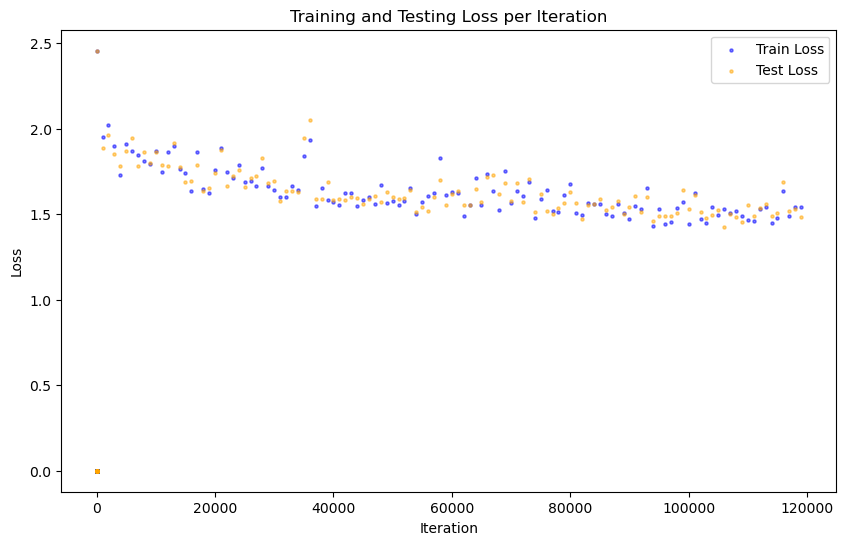

In [22]:
csv_path = os.path.join(base_dir, 'loss_results', filename + '.csv')
data = np.loadtxt(csv_path, delimiter=",", skiprows=1)  # Skip the header row
iterations = data[:, 0]
train_loss = data[:, 1]
test_loss = data[:, 2]

# Plot our data
plt.figure(figsize=(10, 6))
plt.scatter(iterations, train_loss, color='blue', alpha=0.5, s=5, label='Train Loss')
plt.scatter(iterations, test_loss, color='orange', alpha=0.5, s=5, label='Test Loss')
# plt.xscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Iteration')
plt.legend()
plt.show()

In [23]:
# Generate some text
seed_string = "We the people"
starting_tokens = torch.tensor(tokenizer.encode_as_ids(seed_string)).reshape(1, -1).to(device)
gen_tokens = new_model.generate(starting_tokens, max_new_tokens=100).to('cpu').tolist()[0]
print(tokenizer.decode(gen_tokens))

We the people plan, and pleased; that see, hadnder been, stipulated that the good begin to believe they walked to assume into another watch. What they wouldrog than anything he? Have the oil. HOMian. This is right wing open. The door was great inc Grand not meet the head, and the orders and had excess of allords to the highest price to my| line contove-came. Leology is your two things together. ALEY a conclusion S. "Where


# Helpful for Debugging / Confirmation
---

In [7]:
# Test to ensure that our embeddings are working as expected
embeds = model.token_embedding_table.weight
str = "boy"
tok = tokenizer.encode_as_ids(str)[0]
emb_str = embeds[tok:tok+1, :].T
_, indices = torch.topk((embeds@emb_str).flatten(), 11)
for i, idx in enumerate(indices):
    print(f"Tok {i:>2}: \"{tokenizer.decode(idx.tolist())}\"")

Tok  0: "boy"
Tok  1: "girl"
Tok  2: "child"
Tok  3: "lady"
Tok  4: "young"
Tok  5: "poor"
Tok  6: "little"
Tok  7: "woman"
Tok  8: "dear"
Tok  9: "hood"
Tok 10: "mother"
